### <p style="text-align: right;"> **Ethan Truelove** </p>

# 1. Project: Who is the most valuable player in the NFL?

## 1.1 Background and Motivation

The NFL has longed lacked an actual measure that shows how valuable a player is to their team. Quarterbacks have dominated the MVP race in recent history, winning 9 out of the last 10. On the contrary, only 1 defensive player in NFL history has ever won MVP. However, it has not been shown statistically why one position is more valuable than others. My main goal is to quantify player value into a value that can be highly accurate and easy to understand.

## 1.2 Methodology

I set out to answer this problem by using play by play data scraped from the NFL API. Looking at the data on a play by play basis allows me to analyze each player more precisly than by simply looking at total stats compiled over the course of the season.

Based on statistical analysis of 10 years of NFL play-by-play data, ESPN has created a formula that assigns an "expected points" value to the team with the ball at the start of each play based on the game situation. Expected points (EP) accounts for factors such as down, distance to go, field position, home-field advantage and time remaining. The value it puts out is on a scale from about -3 to 7, and it basically represents "which team is likely to score next, and how many points?" It represents the likely points not just on the current drive but also on the next drive or any subsequent drive until the score changes or the half ends. A lower value indicates a more favorable situation for the defense, and a higher value represents a more favorable situation for the offense. The benefit of having this EP value at the start of each play is that it can be used to measure the success of that play by comparing it to the EP value at the start of the next play. Good offensive plays typically increase EP while incomplete passes or a loss of yards would decrease the EP. The difference in EP from one play to the next is called expected points added or EPA. Because EPA accounts for many factors and scenarios, it is a very accurate measure of how valuable each play is.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None

First I imported the data into a pandas dataframe and set low_memory to false to avoid data type errors.

In [3]:
pbp2019 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2019.csv",low_memory=False)

In [4]:
pbp2019

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,35,2019090500,CHI,GB,GB,away,CHI,CHI,35.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,50,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,71,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,95,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,125,2019090500,CHI,GB,GB,away,CHI,GB,85.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
5,155,2019090500,CHI,GB,CHI,home,GB,CHI,57.0,2019-09-05,...,00-0033120,K.Clark,5.0,0,NaN,Defensive Holding,0.0,0.0,0.0,0.0
6,195,2019090500,CHI,GB,CHI,home,GB,CHI,52.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
7,216,2019090500,CHI,GB,CHI,home,GB,GB,47.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8,238,2019090500,CHI,GB,CHI,home,GB,GB,47.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
9,260,2019090500,CHI,GB,CHI,home,GB,GB,40.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


I then removed any data that is not an actual play (kickoffs, end of quarters, etc..), by using the loc function to only use data meeting the requirements of play type = no play, pass, or run and EPA must be a value.

In [5]:
pbp2019 = pbp2019.loc[(pbp2019.play_type.isin(['no_play','pass','run'])) & (pbp2019.epa.isna()==False)]       

In [6]:
pbp2019['desc'].loc[pbp2019['play_type'] == 'no_play']

5        (13:01) (Shotgun) T.Cohen FUMBLES (Aborted) at...
30                             Timeout #1 by CHI at 01:50.
31       (1:50) (Shotgun) M.Trubisky pass incomplete sh...
61       (4:19) (Shotgun) T.Cohen left tackle pushed ob...
73       (:55) (Shotgun) PENALTY on GB-A.Rodgers, False...
78                              Timeout #2 by GB at 00:24.
81                              Timeout #3 by GB at 00:09.
90       (13:17) (No Huddle) A.Rodgers pass incomplete ...
91       (13:11) (Shotgun) A.Rodgers pass incomplete de...
93                              Timeout #1 by GB at 12:59.
95       (12:16) (Shotgun) A.Rodgers scrambles up the m...
107      (5:41) (Shotgun) PENALTY on CHI, Delay of Game...
111      (4:05) (Shotgun) PENALTY on CHI, Delay of Game...
119      (:42) (Shotgun) PENALTY on GB-T.Davis, False S...
127      (13:44) (Shotgun) M.Trubisky pass incomplete d...
128      (13:35) (Shotgun) M.Trubisky pass short middle...
129      (13:13) (Shotgun) M.Trubisky pass deep right t.

Plays marked as no play are often penalties, however these plays are still plays and should be classified as a run or a pass. The lines below seperate plays marked as no plays into runs and passes.

In [7]:
pbp2019.loc[pbp2019.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2019.loc[pbp2019.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'

In [8]:
pbp2019.reset_index(drop=True, inplace=True)

On plays that have penalites most of the time the player name will be null for the player that passed, caught, or ran the ball. By looking through the play description for running plays the player name will be shown right before the direction that they ran in (right, up, left). 

In [9]:
rusher_name_null = pbp2019.loc[(pbp2019['play_type'] == 'run') &
         (pbp2019['rusher_player_name'].isnull())]

In [10]:
rusher_name_null_indices = list(rusher_name_null.index)

In [11]:
for i in rusher_name_null_indices:
    #Split the description on the blank spaces, isolating each word
    desc = pbp2019['desc'].iloc[i].split()
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is right, up, or left
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            #Set rusher_player_name for that play to the word just before the direction
            pbp2019['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass

Repeat same process for passers.

In [12]:
#Create a smaller dataframe with plays where passer_player_name is null
passer_name_null = pbp2019.loc[(pbp2019['play_type'] == 'pass') &
         (pbp2019['passer_player_name'].isnull())]
#Create a list of the indexes/indices for the plays where passer_player_name is null
passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    #Split the description on the blank spaces, isolating each word
    desc = pbp2019['desc'].iloc[i].split()
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is pass
        if desc[j] == 'pass':
            pbp2019['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass
#Change any backwards passes that incorrectly labeled passer_player_name as Backward
pbp2019.loc[pbp2019['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')

Series([], Name: passer_player_name, dtype: bool)

Repeat once more for recievers.

In [13]:
receiver_name_null = pbp2019.loc[(pbp2019['play_type'] == 'pass') & 
                        (pbp2019['receiver_player_name'].isnull()) &
                        (pbp2019['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2019['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2019['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass

I then added a similar metric to EPA called success rate. Success rate is simple, if a play had a positive EPA it is a success, a negative EPA is a failure. EPA is the 68th column in the dataframe so I added success rate into the 69th column and set the deault value to 0.

In [14]:
pbp2019.insert(69, 'success', 0)

In [15]:
pbp2019.loc[pbp2019['epa'] > 0, 'success'] = 1

To show the distribution of plays based on EPA I plotted a histogram of EPA for all plays in the 2019 season thus far. As can be seen, the average EPA is about 0 with a large percentage of plays falling between -1 and 1. 

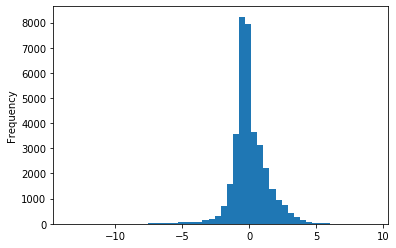

In [16]:
pbp2019['epa'].plot.hist(bins=50)

In [17]:
pbp2019['epa'].describe()

count    36399.000000
mean         0.016718
std          1.372274
min        -13.494721
25%         -0.648746
50%         -0.128484
75%          0.661075
max          9.244834
Name: epa, dtype: float64

In [18]:
pbp2019['ep'].describe()

count    36391.000000
mean         2.047033
std          1.677736
min         -3.133580
25%          0.814998
50%          1.987231
75%          3.317460
max          6.500900
Name: ep, dtype: float64

To get a better view of run plays vs pass plays I seperated them and plotted them seperately on the same histogram. Run plays offer a higher chance at a stable EPA generally while pass plays offer far more upside.

In [19]:
passEPA = pbp2019['epa'].loc[pbp2019['play_type']=='pass'].mean()
runEPA = pbp2019['epa'].loc[pbp2019['play_type']=='run'].mean()

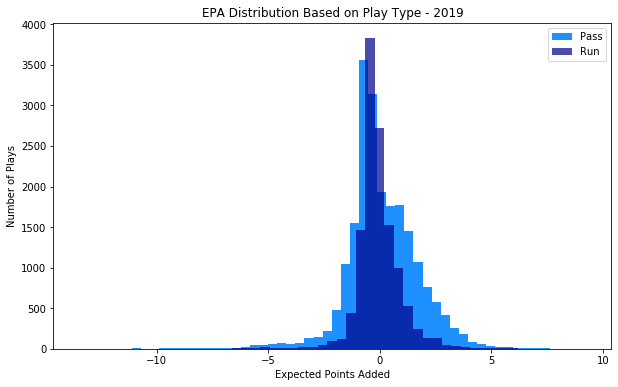

The average EPA on a pass is 0.07989071778975035
The average EPA on a run is -0.07378199428626521


In [20]:
plt.figure(1, figsize=(10,6))
plt.hist(pbp2019['epa'].loc[pbp2019['play_type']=='pass'], bins=50, label='Pass', color='dodgerblue')
plt.hist(pbp2019['epa'].loc[pbp2019['play_type']=='run'], bins=50, label='Run', alpha=.7, color='darkblue')
plt.xlabel('Expected Points Added')
plt.ylabel('Number of Plays')
plt.title('EPA Distribution Based on Play Type - 2019')
plt.legend()
plt.savefig('epa_dist.png', dpi=400)
plt.show()
print("The average EPA on a pass is",passEPA)
print("The average EPA on a run is",runEPA)

As shown above the mean EPA on pass plays is greater than the mean EPA on run plays meaning in general passing will be more valuable than rushing.

MVPs almost always come from highly successful offenses, in order to make it easier to read EPA by team I imported team logos.

In [21]:
import os
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [22]:
urls = pd.read_csv('https://raw.githubusercontent.com/statsbylopez/BlogPosts/master/nfl_teamlogos.csv')
for i in range(0,len(urls)):
    urllib.request.urlretrieve(urls['url'].iloc[i], os.getcwd() + '\\NFL\\' + urls['team'].iloc[i] + '.png')

In [23]:
def getImage(path): 
    return OffsetImage(plt.imread(path), zoom=.5)

In [24]:
logos = os.listdir(os.getcwd() + '\\NFL')

logo_paths = []

for i in logos:
    logo_paths.append(os.getcwd() + '\\NFL\\' + str(i))

Next I plotted team EPA on run plays vs team EPA on pass plays. I also plotted the laegue average EPA for both types of plays to make it easier to quantify which teams are good and which teams are bad.

In [25]:
EPA = pbp2019.loc[pbp2019['play_type']=='pass'].groupby(by='posteam')[['epa']].mean()
EPA['run'] = pbp2019.loc[pbp2019['play_type']=='run'].groupby(by='posteam')[['epa']].mean()
EPA.columns = [['pass','run']]

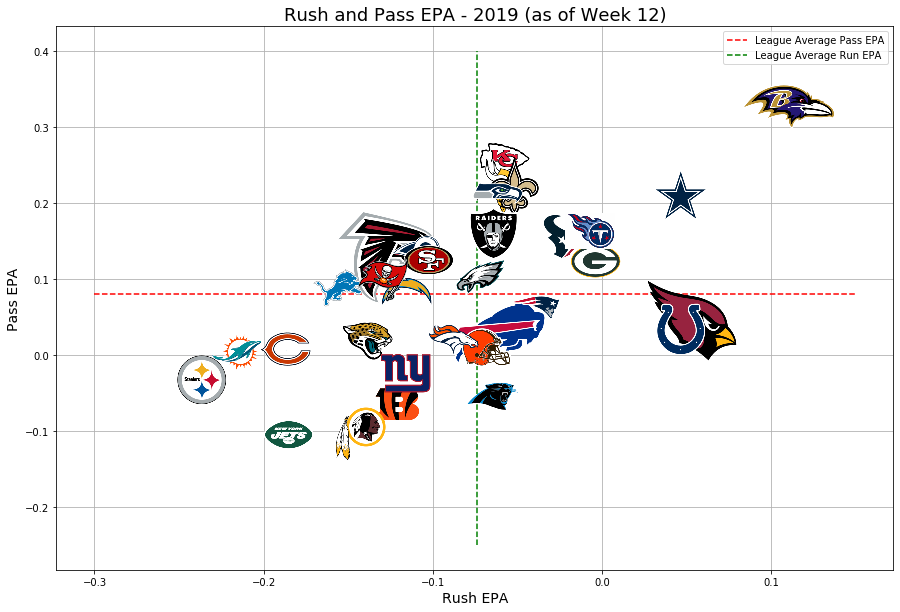

In [26]:
b = EPA['pass'].values
a = EPA['run'].values
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(a,b,s=.001)
plt.hlines(passEPA,-.3,.15,linestyles='dashed',label='League Average Pass EPA',colors='red')
plt.vlines(runEPA,-0.25,.4,linestyles='dashed',label='League Average Run EPA',colors='green')


for x0, y0, path in zip(a, b, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=3)
    ax.add_artist(ab)
    
ax.set_xlabel('Rush EPA', fontsize=14)
ax.set_ylabel('Pass EPA', fontsize=14)
ax.set_title('Rush and Pass EPA - 2019 (as of Week 12)',fontsize=18)
ax.grid()
ax.legend()
plt.savefig('teamEPA.png', dpi=400)


The Ravens are clearly the best offense in the league measuring far above league average in both rush and pass EPA. Meanwhile the Redskins are an example of a terrible team, measuring far below league average on both pass and rush EPA.

To get a slightly different view of offensive efficiency I also plotted team Pass success rate vs team Rush success rate.

In [27]:
success_rates = pbp2019.loc[pbp2019['play_type']=='pass'].groupby(by='posteam')[['success']].mean()

success_rates['run_success'] = pbp2019.loc[pbp2019['play_type']=='run'].groupby(by='posteam')[['success']].mean()

success_rates.columns = [['pass_success','run_success']]

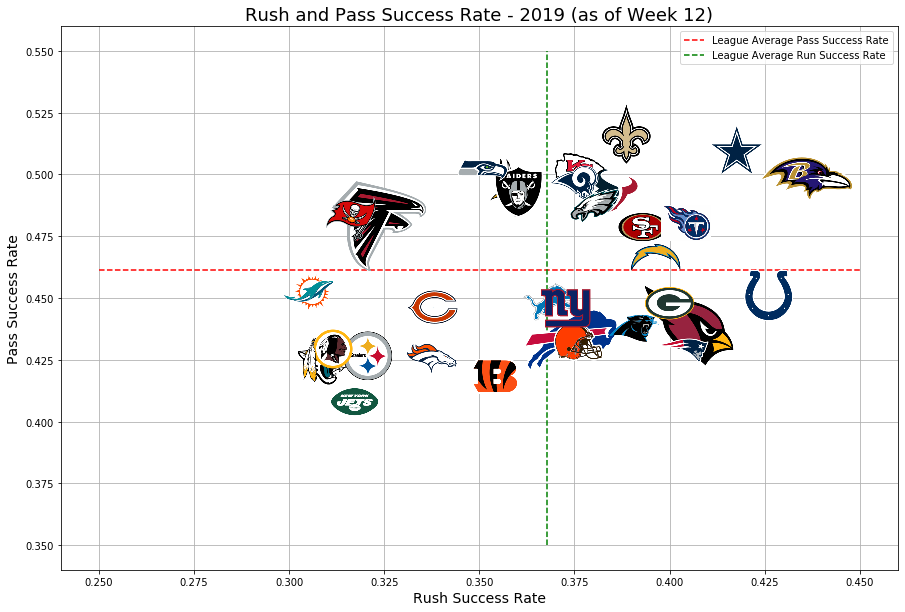

In [28]:

x = success_rates['run_success'].values
y = success_rates['pass_success'].values
x_mean = x.mean()
y_mean = y.mean()


fig, ax = plt.subplots(figsize=(15,10))


ax.scatter(x, y, s=.001)
plt.hlines(y_mean,.25,.45,linestyles='dashed',label='League Average Pass Success Rate',colors='red')
plt.vlines(x_mean,.35,.55,linestyles='dashed',label='League Average Run Success Rate',colors='g')

for x0, y0, path in zip(x, y, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=3)
    ax.add_artist(ab)
    

ax.set_xlabel('Rush Success Rate', fontsize=14)
ax.set_ylabel('Pass Success Rate', fontsize=14)
ax.set_title('Rush and Pass Success Rate - 2019 (as of Week 12)', fontsize=18)
ax.grid()
ax.legend()
plt.savefig('rush-pass-success.png', dpi=400)

This paints a similar picture, although the Cowboys have entered a tier similar to the Ravens. The difference in EPA vs Success Rate can be thought of as plays with higher EPA are weighed less. For example a 50 yard touchdown would provide a big boost in EPA but that same touchdown is simply just marked as a success in success rate.

MVPs also tend to come from good teams, in this context, teams with high EPA on offense and defense.

In [29]:
offensiveEPA = pbp2019.groupby(by='posteam')[['epa']].mean()

In [30]:
defensiveEPA = pbp2019.groupby(by='defteam')[['epa']].mean()
defensiveEPA = defensiveEPA*(-1)

In [31]:
D_EPA = defensiveEPA.values
O_EPA = offensiveEPA.values
D_mean = D_EPA.mean()
O_mean = O_EPA.mean()

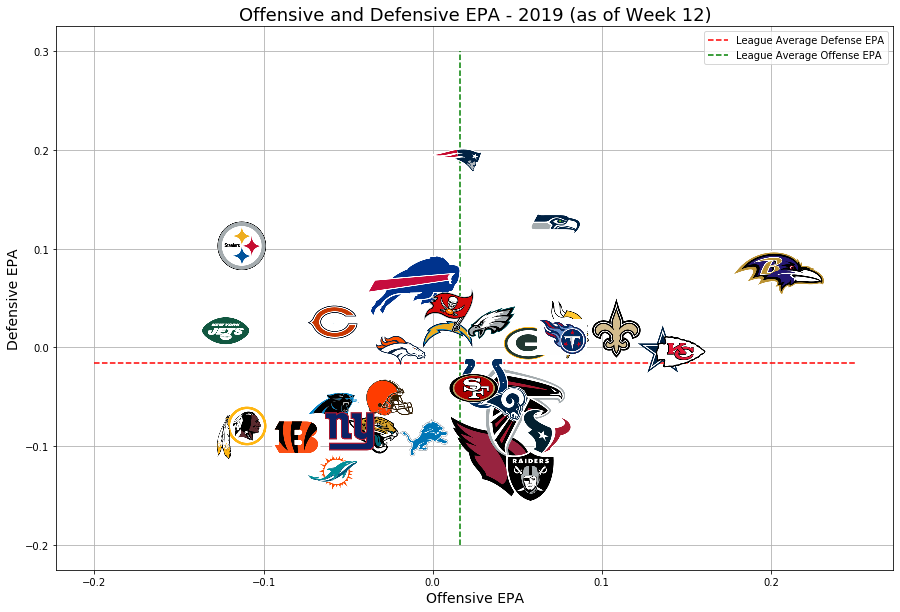

In [32]:
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(O_EPA, D_EPA, s=.001)
plt.hlines(D_mean,-.2,.25,linestyles='dashed',label='League Average Defense EPA',colors='red')
plt.vlines(O_mean,-.2,.3,linestyles='dashed',label='League Average Offense EPA',colors='green')
for x0, y0, path in zip(O_EPA, D_EPA, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=2)
    ax.add_artist(ab)
    
ax.set_xlabel('Offensive EPA', fontsize=14)
ax.set_ylabel('Defensive EPA', fontsize=14)
ax.set_title('Offensive and Defensive EPA - 2019 (as of Week 12)', fontsize=18)
ax.grid()
ax.legend()

The Ravens are once again ahead of the pack in this metric with the Patriots and Seahawks trailing closely.

I then defined functions that can measure the EPA of each individual player and show the opportunity of each player as well as the EPA/play. I also set thresholds for opportunity to keep out players who may have been highly efficient on a small number of total plays.

In [33]:
def QB_EPA(i):
    NFL_QB_EPA = i.loc[(i['play_type']=='pass') 
    & (i['down']<=4)].groupby(by='passer_player_name')[['epa']].mean()
    NFL_QB_EPA['attempts'] = i.loc[(i['play_type']=='pass') 
    & (i['down']<=4)].groupby(by='passer_player_name')['epa'].count()
    NFL_QB_EPA['Total EPA'] = i.loc[(i['play_type']=='pass') 
    & (i['down']<=4)].groupby(by='passer_player_name')[['epa']].sum()
    NFL_QB_EPA.sort_values('epa',ascending=False,inplace=True)
    NFL_QB_EPA = NFL_QB_EPA.loc[NFL_QB_EPA['attempts'] > 300]
    NFL_QB_EPA = NFL_QB_EPA.round({'epa':3, 'Total EPA':2})
    print (NFL_QB_EPA.head())

In [34]:
def WR_EPA(i):
    NFL_WR_EPA = i.loc[(i['play_type']=='pass') 
      & (i['down']<=4)].groupby(by='receiver_player_name')[['epa']].mean()
    NFL_WR_EPA['targets'] = i.loc[(i['play_type']=='pass') 
      & (i['down']<=4)].groupby(by='receiver_player_name')['epa'].count()
    NFL_WR_EPA['Total EPA'] = i.loc[(i['play_type']=='pass') 
      & (i['down']<=4)].groupby(by='receiver_player_name')[['epa']].sum()
    NFL_WR_EPA.sort_values('epa',ascending=False,inplace=True)
    NFL_WR_EPA = NFL_WR_EPA.loc[NFL_WR_EPA['targets'] > 80]
    NFL_WR_EPA = NFL_WR_EPA.round({'epa':3, 'Total EPA':2})
    print (NFL_WR_EPA.head())

In [35]:
def RB_EPA(i):
    NFL_RB_EPA = i.loc[(i['play_type']=='run') 
    & (i['down']<=4)].groupby(by='rusher_player_name')[['epa']].mean()
    NFL_RB_EPA['attempts'] = i.loc[(i['play_type']=='run') 
    & (i['down']<=4)].groupby(by='rusher_player_name')['epa'].count()
    NFL_RB_EPA['Total EPA'] = i.loc[(i['play_type']=='run') 
    & (i['down']<=4)].groupby(by='rusher_player_name')[['epa']].sum()
    NFL_RB_EPA.sort_values('epa',ascending=False,inplace=True)
    NFL_RB_EPA = NFL_RB_EPA.loc[NFL_RB_EPA['attempts'] > 100]
    NFL_RB_EPA = NFL_RB_EPA.round({'epa':3, 'Total EPA':2})
    print (NFL_RB_EPA.head())

In [36]:
NFL_WR_EPA = pbp2019.loc[(pbp2019['play_type']=='pass') & (pbp2019['down']<=4)].groupby(by='receiver_player_name')[['epa']].mean()
NFL_WR_EPA['targets'] = pbp2019.loc[(pbp2019['play_type']=='pass') & (pbp2019['down']<=4)].groupby(by='receiver_player_name')['epa'].count()
NFL_WR_EPA['Total EPA'] = pbp2019.loc[(pbp2019['play_type']=='pass') & (pbp2019['down']<=4)].groupby(by='receiver_player_name')[['epa']].sum()
NFL_WR_EPA.sort_values('epa',ascending=False,inplace=True)
NFL_WR_EPA = NFL_WR_EPA.loc[NFL_WR_EPA['targets'] > 80]
NFL_WR_EPA = NFL_WR_EPA.round({'epa':3, 'success':2, 'yards_gained':1})
NFL_WR_EPA

,epa,targets,Total EPA
receiver_player_name,,,
C.Godwin,0.679,121,82.188271
T.Hill,0.619,112,69.376559
M.Thomas,0.599,190,113.727185
C.Ridley,0.548,93,51.000104
S.Diggs,0.528,97,51.231683
T.Lockett,0.521,113,58.845493
A.Brown,0.510,94,47.951563
G.Kittle,0.496,112,55.547673
C.Kupp,0.485,137,66.384193


In [37]:
NFL_RB_EPA = pbp2019.loc[(pbp2019['play_type']=='run') & (pbp2019['down']<=4)].groupby(by='rusher_player_name')[['epa']].mean()
NFL_RB_EPA['attempts'] = pbp2019.loc[(pbp2019['play_type']=='run') & (pbp2019['down']<=4)].groupby(by='rusher_player_name')['epa'].count()
NFL_RB_EPA['Total EPA'] = pbp2019.loc[(pbp2019['play_type']=='run') & (pbp2019['down']<=4)].groupby(by='rusher_player_name')[['epa']].sum()
NFL_RB_EPA.sort_values('epa',ascending=False,inplace=True)
NFL_RB_EPA = NFL_RB_EPA.loc[NFL_RB_EPA['attempts'] > 100]
NFL_RB_EPA = NFL_RB_EPA.round({'epa':3, 'success':2, 'yards_gained':1})
NFL_RB_EPA

,epa,attempts,Total EPA
rusher_player_name,,,
L.Jackson,0.261,123,32.135554
K.Drake,0.073,171,12.568268
M.Ingram,0.068,117,7.974106
G.Edwards,0.052,138,7.196789
A.Jones,0.033,242,8.090835
R.Mostert,0.032,139,4.482818
D.Cook,0.029,257,7.474482
E.Elliott,0.025,309,7.792223
J.Williams,0.018,156,2.762495


To show the total value of all skill players I plotted the Total EPA vs opportunity. 

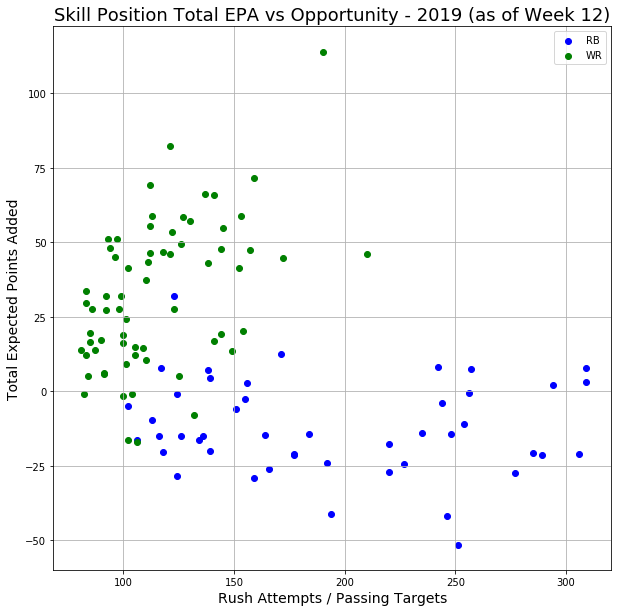

In [38]:
# plot total EPA vs attempts / targets for all skill players
rb_T_EPA = NFL_RB_EPA['Total EPA'].values
rbA = NFL_RB_EPA['attempts'].values
wr_T_EPA = NFL_WR_EPA['Total EPA'].values
wrA = NFL_WR_EPA['targets'].values

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(rbA, rb_T_EPA,label='RB',color='blue')
ax.scatter(wrA, wr_T_EPA,label='WR',color='green')


ax.set_xlabel('Rush Attempts / Passing Targets', fontsize=14)
ax.set_ylabel('Total Expected Points Added', fontsize=14)
ax.set_title('Skill Position Total EPA vs Opportunity - 2019 (as of Week 12)', fontsize=18)
ax.grid()
ax.legend()
plt.savefig('Skill-position-Total-EPA.png', dpi=400)

As can be clearly seen, running backs really have no place in the MVP conversation. Even the most valuable running back only contributes about 14 total EPA on about 220 attempts, meanwhile the most valuable reciever contributes 77 EPA on only 128 attempts.

In [39]:
NFL_QB_EPA = pbp2019.loc[(pbp2019['play_type']=='pass') & (pbp2019['down']<=4)].groupby(by='passer_player_name')[['epa']].mean()
NFL_QB_EPA['attempts'] = pbp2019.loc[(pbp2019['play_type']=='pass') & (pbp2019['down']<=4)].groupby(by='passer_player_name')['epa'].count()
NFL_QB_EPA['Total EPA'] = pbp2019.loc[(pbp2019['play_type']=='pass') & (pbp2019['down']<=4)].groupby(by='passer_player_name')[['epa']].sum()
NFL_QB_EPA.sort_values('epa',ascending=False,inplace=True)
NFL_QB_EPA = NFL_QB_EPA.loc[NFL_QB_EPA['attempts'] > 300]
NFL_QB_EPA = NFL_QB_EPA.round({'epa':3, 'Total EPA':2})
NFL_QB_EPA

,epa,attempts,Total EPA
passer_player_name,,,
L.Jackson,0.318,443,140.97
D.Brees,0.291,405,117.96
P.Mahomes,0.272,552,149.88
M.Stafford,0.271,317,85.84
K.Cousins,0.224,498,111.38
R.Tannehill,0.206,329,67.72
D.Prescott,0.203,647,131.45
J.Garoppolo,0.196,537,105.27
D.Carr,0.156,555,86.55


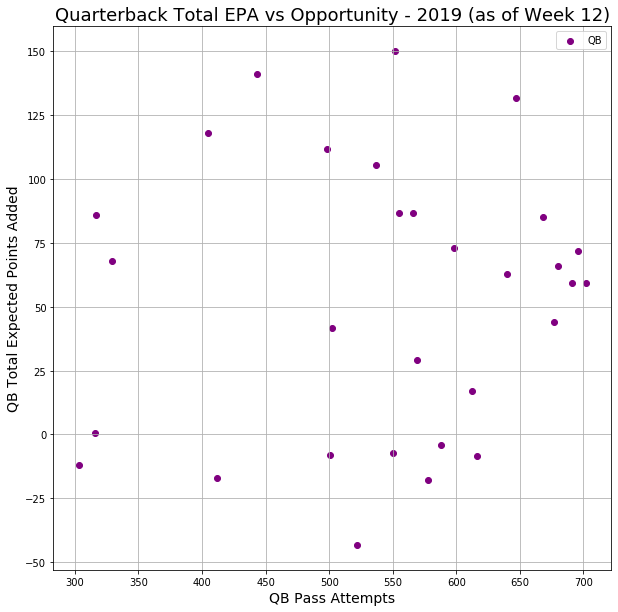

In [40]:
qb_T_EPA = NFL_QB_EPA['Total EPA'].values
qbA = NFL_QB_EPA['attempts'].values


fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(qbA, qb_T_EPA,label='QB',color='purple')


ax.set_xlabel('QB Pass Attempts', fontsize=14)
ax.set_ylabel('QB Total Expected Points Added', fontsize=14)
ax.set_title('Quarterback Total EPA vs Opportunity - 2019 (as of Week 12)', fontsize=18)
ax.grid()
ax.legend()
plt.savefig('QB-total-EPA.png', dpi=400)

As can be seen the MVP trophy should clearly go to the most efficient QB, as QBs provide a much higher Total EPA compared to other positions. The highest QB has a Total EPA greater than 110 while no skill player has a Total EPA greater than 80.


So MVP = QB with highest EPA/play that meets opporunity threshold ( > 300 pass attempts).

## 1.3 Results

Based on how efficient the Ravens offense as a whole is, it is no surprise to see their QB Lamar Jackson as the favorite to win the MVP based on the methods I used.

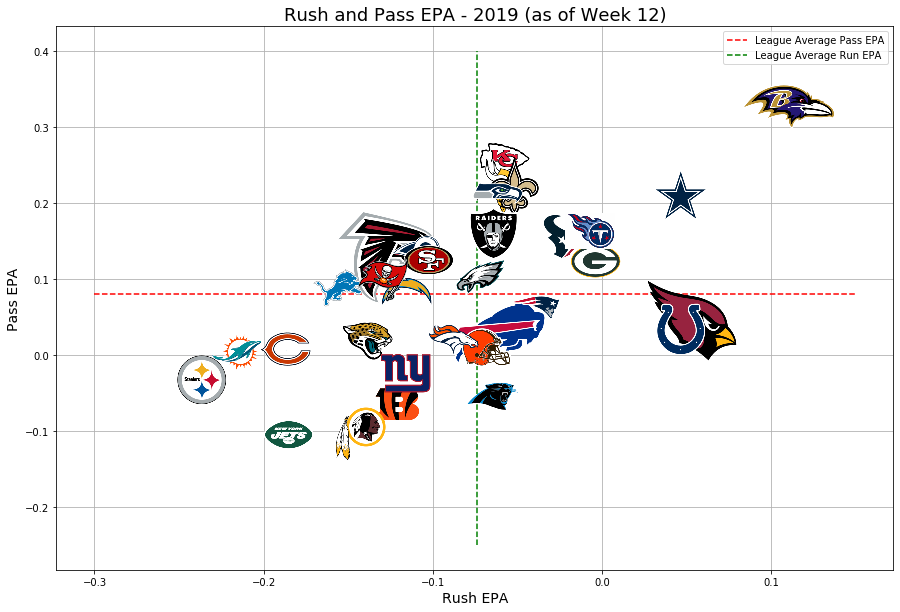

In [41]:
b = EPA['pass'].values
a = EPA['run'].values
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(a,b,s=.001)
plt.hlines(passEPA,-.3,.15,linestyles='dashed',label='League Average Pass EPA',colors='red')
plt.vlines(runEPA,-0.25,.4,linestyles='dashed',label='League Average Run EPA',colors='green')

for x0, y0, path in zip(a, b, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=3)
    ax.add_artist(ab)
    
ax.set_xlabel('Rush EPA', fontsize=14)
ax.set_ylabel('Pass EPA', fontsize=14)
ax.set_title('Rush and Pass EPA - 2019 (as of Week 12)',fontsize=18)
ax.grid()
ax.legend()

In [42]:
WR_EPA(pbp2019)
RB_EPA(pbp2019)
QB_EPA(pbp2019)
print("The model says the 2019 MVP should be Lamar Jackson ( As of Week 12 )")
print("The actual 2019 MVP is TBD")

                        epa  targets  Total EPA
receiver_player_name                           
C.Godwin              0.679      121      82.19
T.Hill                0.619      112      69.38
M.Thomas              0.599      190     113.73
C.Ridley              0.548       93      51.00
S.Diggs               0.528       97      51.23
                      epa  attempts  Total EPA
rusher_player_name                            
L.Jackson           0.261       123      32.14
K.Drake             0.073       171      12.57
M.Ingram            0.068       117       7.97
G.Edwards           0.052       138       7.20
A.Jones             0.033       242       8.09
                      epa  attempts  Total EPA
passer_player_name                            
L.Jackson           0.318       443     140.97
D.Brees             0.291       405     117.96
P.Mahomes           0.272       552     149.88
M.Stafford          0.271       317      85.84
K.Cousins           0.224       498     111.38
The mo

## 1.4 Historical Accuracy

I was interested in testing the accuracy of my methodology. To do this I imported the last 10 years of play by play data and used my methods to find the projected MVP for each year based on EPA. I then compared my findings to who actually won the MVP that season.

## 2009

In [43]:
pbp2009 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2009.csv",low_memory=False)
pbp2009 = pbp2009.loc[(pbp2009.play_type.isin(['no_play','pass','run'])) &
                (pbp2009.epa.isna()==False)]   
pbp2009['desc'].loc[pbp2009['play_type'] == 'no_play']
pbp2009.loc[pbp2009.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2009.loc[pbp2009.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2009.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2009.loc[(pbp2009['play_type'] == 'run') &
         (pbp2009['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2009['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2009['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass


passer_name_null = pbp2009.loc[(pbp2009['play_type'] == 'pass') &
         (pbp2009['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2009['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2009['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2009.loc[pbp2009['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2009.loc[(pbp2009['play_type'] == 'pass') & 
                        (pbp2009['receiver_player_name'].isnull()) &
                        (pbp2009['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2009['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2009['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass


In [44]:
WR_EPA(pbp2009)
RB_EPA(pbp2009)
QB_EPA(pbp2009)
print("The model says the 2009 MVP should be Phillip Rivers.")
print("The actual 2009 MVP was Peyton Manning.")

                        epa  targets  Total EPA
receiver_player_name                           
V.Jackson             0.719      107      76.94
S.Rice                0.693      127      87.97
M.Austin              0.638      124      79.07
A.Gates               0.616      115      70.80
M.Colston             0.565      107      60.43
                      epa  attempts  Total EPA
rusher_player_name                            
W.McGahee           0.084       110       9.21
J.Charles           0.078       191      14.89
J.Stewart           0.065       222      14.41
C.Johnson           0.047       373      17.46
P.Thomas            0.041       152       6.22
                      epa  attempts  Total EPA
passer_player_name                            
P.Rivers            0.329       533     175.28
P.Manning           0.313       605     189.45
D.Brees             0.284       555     157.86
B.Favre             0.235       592     139.28
T.Brady             0.229       612     140.16
The mo

In 2009 the model was wrong but only slightly as it had the actual winner, Peyton Manning as a close second behind the projected MVP, Phillip Rivers.

## 2010

In [45]:
pbp2010 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2010.csv",low_memory=False)
pbp2010 = pbp2010.loc[(pbp2010.play_type.isin(['no_play','pass','run'])) &
                (pbp2010.epa.isna()==False)]   
pbp2010['desc'].loc[pbp2010['play_type'] == 'no_play']
pbp2010.loc[pbp2010.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2010.loc[pbp2010.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2010.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2010.loc[(pbp2010['play_type'] == 'run') &
         (pbp2010['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2010['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2010['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass


passer_name_null = pbp2010.loc[(pbp2010['play_type'] == 'pass') &
         (pbp2010['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2010['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2010['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2010.loc[pbp2010['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2010.loc[(pbp2010['play_type'] == 'pass') & 
                        (pbp2010['receiver_player_name'].isnull()) &
                        (pbp2010['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2010['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2010['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass


In [46]:
WR_EPA(pbp2010)
RB_EPA(pbp2010)
QB_EPA(pbp2010)
print("The model says the 2010 MVP should be Tom Brady.")
print("The actual 2010 MVP was Tom Brady.")

                        epa  targets  Total EPA
receiver_player_name                           
M.Wallace             0.580      101      58.63
V.Davis               0.466       94      43.81
D.Jackson             0.443       96      42.54
D.Mason               0.440      101      44.49
G.Jennings            0.436      124      54.09
                      epa  attempts  Total EPA
rusher_player_name                            
J.Charles           0.130       239      31.15
B.Green-Ellis       0.090       235      21.26
L.McCoy             0.053       211      11.28
C.Ivory             0.048       140       6.66
A.Foster            0.029       331       9.65
                      epa  attempts  Total EPA
passer_player_name                            
T.Brady             0.239       546     130.31
P.Rivers            0.213       595     126.52
M.Ryan              0.192       577     110.96
P.Manning           0.186       718     133.57
B.Roethlisberger    0.171       428      73.12
The mo

In 2010, the model was correct.

## 2011

In [47]:
pbp2011 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2011.csv",low_memory=False)
pbp2011 = pbp2011.loc[(pbp2011.play_type.isin(['no_play','pass','run'])) &
                (pbp2011.epa.isna()==False)]   
pbp2011['desc'].loc[pbp2011['play_type'] == 'no_play']
pbp2011.loc[pbp2011.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2011.loc[pbp2011.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2011.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2011.loc[(pbp2011['play_type'] == 'run') &
         (pbp2011['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2011['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2011['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass


passer_name_null = pbp2011.loc[(pbp2011['play_type'] == 'pass') &
         (pbp2011['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2011['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2011['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2011.loc[pbp2011['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2011.loc[(pbp2011['play_type'] == 'pass') & 
                        (pbp2011['receiver_player_name'].isnull()) &
                        (pbp2011['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2011['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2011['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass

In [48]:
WR_EPA(pbp2011)
RB_EPA(pbp2011)
QB_EPA(pbp2011)
print("The model says the 2011 MVP should be Aaron Rodgers.")
print("The actual 2011 MVP was Aaron Rodgers.")

                        epa  targets  Total EPA
receiver_player_name                           
J.Nelson              0.864       96      82.91
R.Gronkowski          0.741      127      94.12
M.Colston             0.722      112      80.87
V.Cruz                0.588      132      77.65
D.Baldwin             0.558       86      47.96
                      epa  attempts  Total EPA
rusher_player_name                            
P.Thomas            0.123       113      13.93
J.Stewart           0.105       146      15.35
C.Spiller           0.054       112       6.00
L.McCoy             0.053       274      14.56
D.Murray            0.050       169       8.43
                      epa  attempts  Total EPA
passer_player_name                            
A.Rodgers           0.397       567     225.05
D.Brees             0.338       726     245.73
T.Brady             0.269       672     180.65
M.Schaub            0.227       316      71.75
T.Romo              0.166       569      94.40
The mo

In 2011, the model was correct.

## 2012

In [49]:
pbp2012 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2012.csv",low_memory=False)
pbp2012 = pbp2012.loc[(pbp2012.play_type.isin(['no_play','pass','run'])) &
                (pbp2012.epa.isna()==False)]   
pbp2012['desc'].loc[pbp2012['play_type'] == 'no_play']
pbp2012.loc[pbp2012.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2012.loc[pbp2012.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2012.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2012.loc[(pbp2012['play_type'] == 'run') &
         (pbp2012['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2012['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2012['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass


passer_name_null = pbp2012.loc[(pbp2012['play_type'] == 'pass') &
         (pbp2012['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2012['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2012['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2012.loc[pbp2012['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2012.loc[(pbp2012['play_type'] == 'pass') & 
                        (pbp2012['receiver_player_name'].isnull()) &
                        (pbp2012['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2012['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2012['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass
        

In [50]:
WR_EPA(pbp2012)
RB_EPA(pbp2012)
QB_EPA(pbp2012)
print("The model says the 2012 MVP should be Tom Brady.")
print("The actual 2012 MVP was Adrian Peterson.")

                        epa  targets  Total EPA
receiver_player_name                           
R.Gronkowski          0.649       81      52.57
L.Moore               0.578      105      60.66
E.Decker              0.530      124      65.70
S.Rice                0.510       83      42.30
T.Gonzalez            0.509      126      64.17
                      epa  attempts  Total EPA
rusher_player_name                            
A.Peterson          0.074       354      26.06
C.Spiller           0.050       212      10.66
M.Lynch             0.018       322       5.83
S.Ridley           -0.002       295      -0.68
J.Charles          -0.007       288      -2.09
                      epa  attempts  Total EPA
passer_player_name                            
T.Brady             0.275       697     191.49
P.Manning           0.272       634     172.31
M.Ryan              0.229       672     154.21
A.Rodgers           0.206       646     133.37
R.Wilson            0.187       448      83.80
The mo

In 2012 the model was incorrect, however I think this is due to voters not understanding how little effect running backs have on team success. Although Adrian Peterson had maybe the best running back season in modern NFL history, he had a total EPA that was about 1/8th of what projected MVP, Tom Brady contributed.

## 2013

In [51]:
pbp2013 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2013.csv",low_memory=False)
pbp2013 = pbp2013.loc[(pbp2013.play_type.isin(['no_play','pass','run'])) &
                (pbp2013.epa.isna()==False)]   
pbp2013['desc'].loc[pbp2013['play_type'] == 'no_play']
pbp2013.loc[pbp2013.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2013.loc[pbp2013.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2013.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2013.loc[(pbp2013['play_type'] == 'run') &
         (pbp2013['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2013['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2013['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass


passer_name_null = pbp2013.loc[(pbp2013['play_type'] == 'pass') &
         (pbp2013['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2013['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2013['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2013.loc[pbp2013['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2013.loc[(pbp2013['play_type'] == 'pass') & 
                        (pbp2013['receiver_player_name'].isnull()) &
                        (pbp2013['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2013['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2013['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass

In [52]:
WR_EPA(pbp2013)
RB_EPA(pbp2013)
QB_EPA(pbp2013)
print("The model says the 2013 MVP should be Peyton Manning.")
print("The actual 2013 MVP was Peyton Manning.")

                        epa  targets  Total EPA
receiver_player_name                           
A.Boldin              0.649      131      85.08
K.Allen               0.558      106      59.16
D.Jackson             0.534      129      68.90
J.Thomas              0.497       93      46.18
M.Colston             0.482      115      55.45
                      epa  attempts  Total EPA
rusher_player_name                            
D.Brown             0.104       103      10.74
D.Murray            0.061       221      13.48
M.Ball              0.053       119       6.33
A.Ellington         0.038       120       4.62
F.Jackson           0.037       212       7.75
                      epa  attempts  Total EPA
passer_player_name                            
P.Manning           0.351       716     251.62
P.Rivers            0.301       609     183.39
A.Rodgers           0.275       327      89.86
N.Foles             0.256       361      92.40
D.Brees             0.214       722     154.35
The mo

In 2013 the model was correct.

## 2014

In [53]:
pbp2014 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2014.csv",low_memory=False)
pbp2014 = pbp2014.loc[(pbp2014.play_type.isin(['no_play','pass','run'])) & (pbp2014.epa.isna()==False)]   
pbp2014['desc'].loc[pbp2014['play_type'] == 'no_play']
pbp2014.loc[pbp2014.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2014.loc[pbp2014.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2014.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2014.loc[(pbp2014['play_type'] == 'run') &
         (pbp2014['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2014['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2014['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass
        
passer_name_null = pbp2014.loc[(pbp2014['play_type'] == 'pass') &
         (pbp2014['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2014['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2014['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2014.loc[pbp2014['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2014.loc[(pbp2014['play_type'] == 'pass') & 
                        (pbp2014['receiver_player_name'].isnull()) &
                        (pbp2014['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2014['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2014['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass
        

In [54]:
WR_EPA(pbp2014)
RB_EPA(pbp2014)
QB_EPA(pbp2014)
print("The model says the 2014 MVP should be Aaron Rodgers.")
print("The actual 2014 MVP was Aaron Rodgers.")

                        epa  targets  Total EPA
receiver_player_name                           
K.Stills              0.765       83      63.49
R.Cobb                0.691      127      87.70
E.Sanders             0.598      143      85.58
J.Nelson              0.585      152      88.89
T.Kelce               0.556       90      50.05
                      epa  attempts  Total EPA
rusher_player_name                            
J.Charles           0.045       210       9.46
J.Forsett           0.041       240       9.84
J.Hill              0.027       224       5.98
M.Lynch             0.027       292       7.77
L.Bell              0.007       295       2.00
                      epa  attempts  Total EPA
passer_player_name                            
A.Rodgers           0.344       577     198.40
T.Romo              0.304       489     148.53
B.Roethlisberger    0.250       661     164.99
P.Manning           0.217       650     141.08
D.Brees             0.193       713     137.73
The mo

In 2014 the model was correct.

## 2015

In [55]:
pbp2015 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2015.csv",low_memory=False)
pbp2015 = pbp2015.loc[(pbp2015.play_type.isin(['no_play','pass','run'])) & (pbp2015.epa.isna()==False)]   
pbp2015['desc'].loc[pbp2015['play_type'] == 'no_play']
pbp2015.loc[pbp2015.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2015.loc[pbp2015.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2015.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2015.loc[(pbp2015['play_type'] == 'run') &
         (pbp2015['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2015['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2015['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass
        
passer_name_null = pbp2015.loc[(pbp2015['play_type'] == 'pass') &
         (pbp2015['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2015['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2015['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2015.loc[pbp2015['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2015.loc[(pbp2015['play_type'] == 'pass') & 
                        (pbp2015['receiver_player_name'].isnull()) &
                        (pbp2015['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2015['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2015['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass
        

In [56]:
WR_EPA(pbp2015)
RB_EPA(pbp2015)
QB_EPA(pbp2015)
print("The model says the 2015 MVP should be Carson Palmer.")
print("The actual 2015 MVP was Cam Newton.")

                        epa  targets  Total EPA
receiver_player_name                           
D.Baldwin             0.723      104      75.20
A.Green               0.616      135      83.18
S.Watkins             0.576       97      55.85
R.Gronkowski          0.522      124      64.68
O.Beckham Jr.         0.521      151      78.70
                      epa  attempts  Total EPA
rusher_player_name                            
De.Williams         0.056       145       8.08
T.Rawls             0.044       152       6.71
M.Ingram            0.022       169       3.75
D.Johnson          -0.009       188      -1.70
L.Bell             -0.017       115      -1.91
                      epa  attempts  Total EPA
passer_player_name                            
C.Palmer            0.321       596     191.18
A.Dalton            0.299       433     129.58
R.Wilson            0.274       544     148.79
B.Roethlisberger    0.242       523     126.49
D.Brees             0.197       691     136.39
The mo

According to the model, Carson Palmer should've easily won the MVP this season as the actual winner, Cam Newton, didn't even finish among the top 5 most efficient Quarterbacks. However, in 2015 Cam Newton had 10 rushing touchdowns which is not factored into the Passing EPA equation. This seems to be another case of voters over valuing rushing production.

## 2016

In [57]:
pbp2016 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2016.csv",low_memory=False)
pbp2016 = pbp2016.loc[(pbp2016.play_type.isin(['no_play','pass','run'])) & (pbp2016.epa.isna()==False)]   
pbp2016['desc'].loc[pbp2016['play_type'] == 'no_play']
pbp2016.loc[pbp2016.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2016.loc[pbp2016.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2016.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2016.loc[(pbp2016['play_type'] == 'run') &
         (pbp2016['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2016['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2016['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass
        
passer_name_null = pbp2016.loc[(pbp2016['play_type'] == 'pass') &
         (pbp2016['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2016['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2016['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2016.loc[pbp2016['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2016.loc[(pbp2016['play_type'] == 'pass') & 
                        (pbp2016['receiver_player_name'].isnull()) &
                        (pbp2016['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2016['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2016['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass
        

In [58]:
WR_EPA(pbp2016)
RB_EPA(pbp2016)
QB_EPA(pbp2016)
print("The model says the 2016 MVP should be Matt Ryan.")
print("The actual 2016 MVP was Matt Ryan.")

                        epa  targets  Total EPA
receiver_player_name                           
T.Kelce               0.647      117      75.65
C.Beasley             0.641       99      63.47
A.Thielen             0.577       94      54.21
C.Brate               0.512       84      43.02
J.Jones               0.502      131      65.75
                      epa  attempts  Total EPA
rusher_player_name                            
M.Gillislee         0.192       105      20.14
B.Powell            0.070       132       9.24
L.McCoy             0.052       238      12.31
D.Freeman           0.031       232       7.22
D.Henry             0.015       115       1.68
                      epa  attempts  Total EPA
passer_player_name                            
M.Ryan              0.353       597     210.88
T.Brady             0.307       472     144.67
D.Prescott          0.238       503     119.48
A.Rodgers           0.228       676     154.39
B.Roethlisberger    0.201       552     111.18
The mo

In 2016 the model was correct.

## 2017

In [59]:
pbp2017 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2017.csv",low_memory=False)
pbp2017 = pbp2017.loc[(pbp2017.play_type.isin(['no_play','pass','run'])) & (pbp2017.epa.isna()==False)]   
pbp2017['desc'].loc[pbp2017['play_type'] == 'no_play']
pbp2017.loc[pbp2017.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2017.loc[pbp2017.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2017.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2017.loc[(pbp2017['play_type'] == 'run') &
         (pbp2017['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2017['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2017['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass
        
passer_name_null = pbp2017.loc[(pbp2017['play_type'] == 'pass') &
         (pbp2017['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2017['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2017['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2017.loc[pbp2017['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2017.loc[(pbp2017['play_type'] == 'pass') & 
                        (pbp2017['receiver_player_name'].isnull()) &
                        (pbp2017['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2017['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2017['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass
        

In [60]:
WR_EPA(pbp2017)
RB_EPA(pbp2017)
QB_EPA(pbp2017)
print("The model says the 2017 MVP should be Tom Brady.")
print("The actual 2017 MVP was Tom Brady.")

                        epa  targets  Total EPA
receiver_player_name                           
R.Gronkowski          0.667      109      72.70
R.Woods               0.551       85      46.86
M.Jones               0.545       99      53.94
D.Adams               0.470      119      55.96
T.Hill                0.467      107      50.00
                      epa  attempts  Total EPA
rusher_player_name                            
A.Kamara            0.237       125      29.62
D.Lewis             0.092       185      16.95
A.Morris            0.008       117       0.95
A.Collins           0.004       215       0.76
K.Hunt             -0.023       280      -6.42
                      epa  attempts  Total EPA
passer_player_name                            
T.Brady             0.270       665     179.49
P.Rivers            0.242       625     151.56
C.Wentz             0.239       487     116.18
M.Ryan              0.206       573     118.29
B.Roethlisberger    0.197       615     121.46
The mo

In 2017 the model was correct.

## 2018

In [61]:
pbp2018 = pd.read_csv("C:\\Users\\etrue\\Downloads\\reg_pbp_2018.csv",low_memory=False)
pbp2018 = pbp2018.loc[(pbp2018.play_type.isin(['no_play','pass','run'])) & (pbp2018.epa.isna()==False)]   
pbp2018['desc'].loc[pbp2018['play_type'] == 'no_play']
pbp2018.loc[pbp2018.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

pbp2018.loc[pbp2018.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'
pbp2018.reset_index(drop=True, inplace=True)
rusher_name_null = pbp2018.loc[(pbp2018['play_type'] == 'run') &
         (pbp2018['rusher_player_name'].isnull())]
rusher_name_null_indices = list(rusher_name_null.index)

for i in rusher_name_null_indices:
    desc = pbp2018['desc'].iloc[i].split()
    
    for j in range(0,len(desc)): 
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            pbp2018['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass
        
passer_name_null = pbp2018.loc[(pbp2018['play_type'] == 'pass') &
         (pbp2018['passer_player_name'].isnull())]

passer_name_null_indices = list(passer_name_null.index)

for i in passer_name_null_indices:
    desc = pbp2018['desc'].iloc[i].split()
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            pbp2018['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

pbp2018.loc[pbp2018['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')
receiver_name_null = pbp2018.loc[(pbp2018['play_type'] == 'pass') & 
                        (pbp2018['receiver_player_name'].isnull()) &
                        (pbp2018['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_name_null_indices = list(receiver_name_null.index)

for i in receiver_name_null_indices:
    desc = pbp2018['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                pbp2018['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass
        

In [62]:
WR_EPA(pbp2018)
RB_EPA(pbp2018)
QB_EPA(pbp2018)
print("The model says the 2017 MVP should be Patrick Mahomes.")
print("The actual 2017 MVP was Patrick Mahomes.")

                        epa  targets  Total EPA
receiver_player_name                           
M.Williams            0.675       84      56.66
T.Boyd                0.633      112      70.86
M.Thomas              0.562      152      85.48
T.Hilton              0.559      124      69.30
A.Jeffery             0.514       94      48.34
                      epa  attempts  Total EPA
rusher_player_name                            
T.Gurley            0.146       258      37.60
L.Jackson           0.113       117      13.26
A.Jones             0.097       135      13.06
A.Kamara            0.091       198      18.06
G.Edwards           0.081       142      11.56
                      epa  attempts  Total EPA
passer_player_name                            
P.Mahomes           0.352       642     225.84
D.Brees             0.347       533     184.91
P.Rivers            0.260       560     145.88
M.Ryan              0.224       674     151.01
J.Goff              0.217       624     135.67
The mo

In 2018 the model was correct.

The model correctly predicts 7 out of the last 10 MVPs. The 3 years it was "incorrect", it chose the actual runner up as the MVP, indicating it was on the right path and in fact the voters may be wrong.

## 1.5 Conclusion

From my results I learned why Quarterbacks win MVP almost every year. Quarterbacks have long dominated the MVP ranks, now I have the numbers to be able to quantify exactly why. I also was suprised to see just how little running back success matters in terms of team success. This will probably be a bit of a shock to most football fans, as the running back touches the ball more than anyone else on the team besides the quarterback.

## 1.5.1 Obstacles

I ran into some obstacles while running these models. One of the biggest problems I faced was trying to factor a Quarterback's rushing EPA into that players Total EPA. This was a small problem as most Quarterbacks in the MVP race are not prolific rushers as well. However, it adds a little bit of noise to the data, making it not quite as accurate as I would like. In the future not accounting for quarterback rushing efficiency could skew my answers, as quarterbacks continue to get more athletic and become more prolific rushers.

I also faced difficulty figuring out ways to quantify defensive production so I just ignored defensive players as MVP candidates. This probably wouldn't change any of my answers, as only one defensive player has won the MVP at all in the last 50 years.

## 1.6 References

1. Pattani, Alok. "Expected points and EPA explained." ESPN, 15 Sept. 2012, www.espn.com/nfl/story/_/id/8379024/nfl-explaining-expected-points-metric. 
2. Yurko, Ron. nflscrapR-data, GitHub repository, https://github.com/ryurko/nflscrapR-data/tree/master/play_by_play_data/regular_season

3. Kania, Mike. "AP NFL Most Valuable Player Winners." ProFootballReference, Sports Reference, www.pro-football-reference.com/awards/ap-nfl-mvp-award.htm. 

